<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
!pip install keras-preprocessing --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 133MB/s]


In [5]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [6]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [7]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [8]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parámetros
max_len = 10

# Tokenización para las entradas (preguntas)
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_sentences)
encoder_input_sequences = tokenizer_inputs.texts_to_sequences(input_sentences)

# Tokenización para las salidas (respuestas)
tokenizer_outputs = Tokenizer(filters='')
tokenizer_outputs.fit_on_texts(output_sentences + output_sentences_inputs)
decoder_output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
decoder_input_sequences = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)

# Diccionarios de palabras a índices
word2idx_inputs = tokenizer_inputs.word_index
word2idx_outputs = tokenizer_outputs.word_index

# Longitudes máximas de las secuencias
max_input_len = max(len(seq) for seq in encoder_input_sequences)
max_out_len = max(len(seq) for seq in decoder_output_sequences)

# Número de palabras únicas en el vocabulario de salida
num_words_output = len(word2idx_outputs) + 1  # +1 para el padding (índice 0)

# Padding de las secuencias
encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=max_out_len, padding='post')

# Crear los targets para el decoder (one-hot encoding)
decoder_targets = np.zeros((len(decoder_output_sequences), max_out_len, num_words_output), dtype='float32')

for i, seq in enumerate(decoder_output_sequences):
    for t, word_idx in enumerate(seq):
        if word_idx != 0:
            decoder_targets[i, t, word_idx] = 1.0

# Mostrar resultados
print("word2idx_inputs:", word2idx_inputs)
print("max_input_len:", max_input_len)
print("word2idx_outputs:", word2idx_outputs)
print("max_out_len:", max_out_len)
print("num_words_output:", num_words_output)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_output_sequences shape:", decoder_output_sequences.shape)
print("decoder_targets shape:", decoder_targets.shape)


word2idx_inputs: {'i': 1, 'you': 2, 'do': 3, 'what': 4, 'a': 5, 'to': 6, 'are': 7, 'for': 8, 'am': 9, 'how': 10, 'hi': 11, 'like': 12, 'living': 13, 'love': 14, 'is': 15, 'have': 16, 'm': 17, 'that': 18, 'hello': 19, 'oh': 20, 'your': 21, 'ok': 22, 'read': 23, 'good': 24, 'yes': 25, 'the': 26, 'it': 27, 'not': 28, 'no': 29, 's': 30, 'any': 31, 'work': 32, 'in': 33, 'u': 34, 'me': 35, 'my': 36, 'about': 37, 'and': 38, 'from': 39, 't': 40, 'of': 41, 'go': 42, 'play': 43, 'today': 44, 'too': 45, 'so': 46, 'don': 47, 'hobbies': 48, 'nice': 49, 'fine': 50, 'name': 51, 'where': 52, 'cool': 53, 'doing': 54, 'there': 55, 'hey': 56, 'know': 57, 'bye': 58, 'see': 59, 'great': 60, 'well': 61, 'favorite': 62, 'sure': 63, 'old': 64, 'games': 65, 'pets': 66, 'why': 67, 'beach': 68, 'sorry': 69, 'at': 70, 'nothing': 71, 'mean': 72, 'lot': 73, 'fun': 74, 'live': 75, 'okay': 76, 'thanks': 77, 'also': 78, 'can': 79, 'student': 80, 'city': 81, 'vegan': 82, 'video': 83, 'girl': 84, 'with': 85, 'yeah': 86,

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [10]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=ee153ca7-df87-463e-8511-35cf0cb3bc99
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:08<00:00, 59.0MB/s]


In [11]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [12]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [13]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Parámetros del Modelo ---
MAX_VOCAB_SIZE = 8000
EMBEDDING_DIM = 300
MAX_INPUT_LEN = 10
MAX_OUT_LEN = 10
N_UNITS = 256  # Aumentar unidades para mayor capacidad de aprendizaje
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 64

# --- Preparar Datos (Asegúrate de que estén definidos encoder_input_sequences, decoder_input_sequences y decoder_targets) ---
# Asegurar el padding de las secuencias a la longitud máxima
encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=MAX_INPUT_LEN, padding='post')
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=MAX_OUT_LEN, padding='post')
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=MAX_OUT_LEN, padding='post')

# Crear los targets del decoder en formato one-hot
num_words_output = len(word2idx_outputs) + 1  # +1 para el índice de padding (0)
decoder_targets = np.zeros((len(decoder_output_sequences), MAX_OUT_LEN, num_words_output), dtype='float32')

for i, seq in enumerate(decoder_output_sequences):
    for t, word_idx in enumerate(seq):
        if word_idx != 0:
            decoder_targets[i, t, word_idx] = 1.0

# --- Definir el Modelo Encoder-Decoder ---

# Encoder
encoder_inputs = Input(shape=(MAX_INPUT_LEN,), name='encoder_inputs')
encoder_embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True, name='encoder_embedding')(encoder_inputs)
encoder_lstm = LSTM(N_UNITS, return_state=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAX_OUT_LEN,), name='decoder_inputs')
decoder_embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True, name='decoder_embedding')(decoder_inputs)
decoder_lstm = LSTM(N_UNITS, return_sequences=True, return_state=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_outputs)

# Compilar el modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# --- Entrenamiento del Modelo ---

# Callback para detener el entrenamiento si no hay mejora en la validación
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 10, 300)        │      2,400,000 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 10)             │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, 10, 300)        │      2,400,000 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 256), (None,   │        570,368 │ encoder_embedding[0][… │
│                           │ 256), (None, 256)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 10, 256),      │        570,368 │ decoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 256)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 10, 1807)       │        464,399 │ decoder_lstm[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,405,135 (24.43 MB)

 Trainable params: 6,405,135 (24.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.0960 - loss: 5.9056 - val_accuracy: 0.1413 - val_loss: 4.3853
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - accuracy: 0.1605 - loss: 3.8199 - val_accuracy: 0.1832 - val_loss: 3.9270
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 483ms/step - accuracy: 0.2207 - loss: 3.2379 - val_accuracy: 0.1930 - val_loss: 3.6904
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - accuracy: 0.2337 - loss: 2.9199 - val_accuracy: 0.2012 - val_loss: 3.5778
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - accuracy: 0.2476 - loss: 2.7875 - val_accuracy: 0.2099 - val_loss: 3.4932
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 508ms/step - accuracy: 0.2597 - loss: 2.6218 - val_accuracy: 0.2137 - val_loss: 3.4373
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 462ms/step - accuracy: 0.2685 - loss: 2.4945 - val_accuracy: 0.2160 - val_loss: 3.4034
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 487ms/step - accuracy: 0.2733 - loss: 2.3788 - 

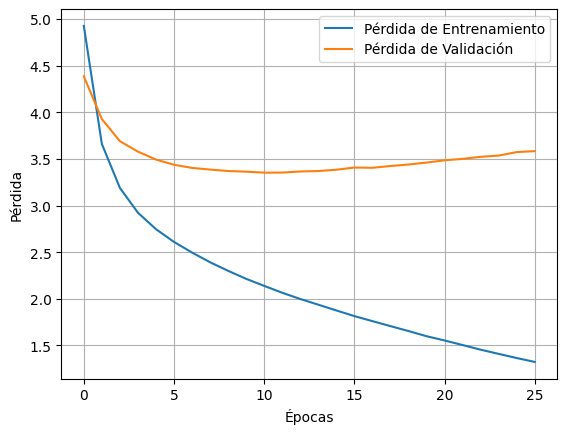

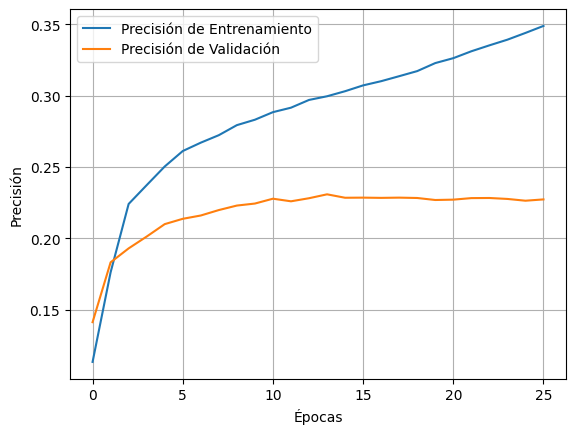

In [14]:
import matplotlib.pyplot as plt

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
import numpy as np

# --- Definir el modelo del Encoder para la Inferencia ---

# Modelo encoder que toma una secuencia de entrada y devuelve los estados ocultos
encoder_model = Model(encoder_inputs, encoder_states)

# --- Definir el modelo del Decoder para la Inferencia ---

# Entradas para los estados ocultos del decoder
decoder_state_input_h = Input(shape=(N_UNITS,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(N_UNITS,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Entrada para las secuencias del decoder
decoder_inputs_inf = Input(shape=(1,), name='decoder_inputs_inf')

# Nueva capa de embedding para el decoder (con los mismos parámetros que en el entrenamiento)
decoder_embedding_inf = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, name='decoder_embedding_inf')(decoder_inputs_inf)

# LSTM del decoder con los estados de entrada
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Capa Dense para predecir la próxima palabra
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo decoder para la inferencia
decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# --- Función para Decodificar una Secuencia ---

def decode_sequence(input_seq):
    # Obtener los estados del encoder
    states_value = encoder_model.predict(input_seq)

    # Generar una secuencia de inicio con el token <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Almacenar la secuencia generada
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Índice de la palabra con mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = None

        # Buscar la palabra correspondiente al índice
        for word, index in word2idx_outputs.items():
            if sampled_token_index == index:
                sampled_word = word
                break

        # Si no se encuentra palabra, detener
        if sampled_word is None:
            break

        # Agregar la palabra a la secuencia generada
        decoded_sentence += ' ' + sampled_word

        # Detener si se alcanza el token <eos> o la longitud máxima
        if sampled_word == '<eos>' or len(decoded_sentence.split()) > MAX_OUT_LEN:
            stop_condition = True

        # Actualizar la secuencia de entrada del decoder
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar los estados del decoder
        states_value = [h, c]

    return decoded_sentence.strip()

# --- Preguntas de Ejemplo para la Inferencia ---

example_questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?"
]

# Preprocesar las preguntas (limpiar y tokenizar)
def preprocess_question(question):
    question = clean_text(question)  # Usar la función de limpieza previamente definida
    sequence = tokenizer_inputs.texts_to_sequences([question])
    return pad_sequences(sequence, maxlen=MAX_INPUT_LEN, padding='post')

# Generar respuestas para las preguntas de ejemplo
for question in example_questions:
    input_sequence = preprocess_question(question)
    decoded_sentence = decode_sequence(input_sequence)
    print(f"Pregunta: {question}")
    print(f"Respuesta Generada: {decoded_sentence}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Pregunta: Do you read?
Respuesta Generada: <eos>
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Pregunta: Do you have any pet?
Respuesta Generada: job <eos>
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Pregunta: Where are you from?
Respuesta Generada: good <eos>
--------------------------------------------------


In [16]:
print("Palabras en el vocabulario del encoder:")
print(list(tokenizer_inputs.word_index.keys())[:50])  # Muestra las primeras 50 palabras


Palabras en el vocabulario del encoder:
['i', 'you', 'do', 'what', 'a', 'to', 'are', 'for', 'am', 'how', 'hi', 'like', 'living', 'love', 'is', 'have', 'm', 'that', 'hello', 'oh', 'your', 'ok', 'read', 'good', 'yes', 'the', 'it', 'not', 'no', 's', 'any', 'work', 'in', 'u', 'me', 'my', 'about', 'and', 'from', 't', 'of', 'go', 'play', 'today', 'too', 'so', 'don', 'hobbies', 'nice', 'fine']


In [17]:
example_questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?"
]

for question in example_questions:
    input_sequence = preprocess_question(question)
    print(f"Pregunta: {question}")
    print(f"Secuencia Tokenizada: {input_sequence}")


Pregunta: Do you read?
Secuencia Tokenizada: [[ 3  2 23  0  0  0  0  0  0  0]]
Pregunta: Do you have any pet?
Secuencia Tokenizada: [[  3   2  16  31 252   0   0   0   0   0]]
Pregunta: Where are you from?
Secuencia Tokenizada: [[52  7  2 39  0  0  0  0  0  0]]


In [18]:
def decode_sequence(input_seq):
    # Codificar la secuencia de entrada para obtener los estados
    states_value = encoder_model.predict(input_seq)

    # Inicializar el input del decoder con el token <SOS>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs["<SOS>"]

    # Almacenar la respuesta generada
    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Obtener el índice de la palabra con mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = {idx: word for word, idx in word2idx_outputs.items()}.get(sampled_token_index)

        # Detener si encontramos el token <EOS> o si la respuesta es demasiado larga
        if sampled_word == "<EOS>" or len(decoded_sentence) > max_out_len:
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)

        # Actualizar la secuencia objetivo (input para el decoder)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar los estados
        states_value = [h, c]

    return " ".join(decoded_sentence)


In [19]:
# Convertir preguntas a secuencias numéricas
test_questions = ["Do you read?", "Do you have any pet?", "Where are you from?"]
test_sequences = tokenizer_inputs.texts_to_sequences(test_questions)
test_sequences = pad_sequences(test_sequences, maxlen=max_input_len, padding="post")

# Generar respuestas
for question, seq in zip(test_questions, test_sequences):
    print(f"Pregunta: {question}")
    response = decode_sequence(seq.reshape(1, -1))
    print(f"Respuesta: {response}")
    print("-" * 30)


Pregunta: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


KeyError: '<SOS>'